# Spaceship Titanic - V9 (V5 + GroupSpend_max_log + 5-Model Ensemble)

**History:**
- V1: CV 0.8265 / LB 0.8020 (49 features, overfit)
- V2: CV 0.8141 / LB 0.8071 (29 features, best LB baseline)
- V3: CV 0.8184 / LB 0.8041 (56 features, TE on interactions = overfit)
- V4: CV 0.8146 / LB 0.8055 (33 features, V2+simple EDA)
- V5: CV 0.8177 / LB **0.8087** (32 features, BEST LB)
- V6: CV 0.8165 / LB 0.8038 (Optuna = overfit on small data)
- V7: CV 0.8159 / LB 0.8038 (Stacking, no help)
- V8: CV 0.8211 / LB TBD (39 features, 5-model ensemble)

**V9 Strategy:** Surgical feature addition from V8 analysis:
- **Base**: V5 (32 features, best LB 0.80874)
- **+1 feature**: `GroupSpend_max_log` — rank 7 in V8 importance (only V8 new feature in top 10)
- **5-model ensemble**: LGB + XGB + CatBoost + ExtraTrees + RandomForest (V2 manual params)
- Total: **33 features**, diverse ensemble for better generalization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings, os

warnings.filterwarnings('ignore')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()
print('V9 Setup complete.')

V9 Setup complete.


In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print(f'Train: {train.shape}, Test: {test.shape}')

train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan
df = pd.concat([train, test], axis=0, ignore_index=True)

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
print(f'Combined: {df.shape}')

Train: (8693, 14), Test: (4277, 13)
Combined: (12970, 15)


## Feature Engineering V9 = V2 Base (identical to V5)

In [3]:
# === V2 Feature Engineering (IDENTICAL copy) ===

# PassengerId
df['_Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
df['GroupSize'] = df.groupby('_Group')['PassengerId'].transform('count')
df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

# Cabin
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
df['Side'] = df['Cabin'].str.split('/').str[2]
df['CabinRegion'] = (df['CabinNum'] // 100).astype(float)

# Name
df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
df.loc[df['Surname'].isna(), 'FamilySize'] = 1

# Booleans
df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})

print('Parsing done.')

Parsing done.


In [4]:
# === V2 Imputation (identical) ===
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df[spend_cols].sum(axis=1) > 0)
df.loc[mask, 'CryoSleep'] = 0

for col in df.select_dtypes(include=[np.number]).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Imputation done. Nulls: {df.isnull().sum().sum()}')

Imputation done. Nulls: 0


In [5]:
# === V2 Spending features (identical) ===
df['TotalSpend'] = df[spend_cols].sum(axis=1)
df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)

for col in spend_cols:
    df[f'{col}_log'] = np.log1p(df[col])

df['LuxurySpend'] = np.log1p(df['Spa'] + df['VRDeck'] + df['RoomService'])
df['BasicSpend'] = np.log1p(df['FoodCourt'] + df['ShoppingMall'])

# Age
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80],
                        labels=[0, 1, 2, 3, 4, 5]).astype(float)
df['IsChild'] = (df['Age'] < 18).astype(float)

# Interactions
df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)

# Group spending
df['GroupSpend_mean'] = df.groupby('_Group')['TotalSpend'].transform('mean')
df['GroupSpend_mean_log'] = np.log1p(df['GroupSpend_mean'])

# Label encoding
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    le = LabelEncoder()
    df[col + '_le'] = le.fit_transform(df[col].astype(str))

# Frequency encoding
for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
    freq = df[col].value_counts(normalize=True)
    df[col + '_freq'] = df[col].map(freq)

print('V2 features done.')

V2 features done.


## V5 Target Encoding (Bayesian smoothed, 10-fold OOF)

In [6]:
# === REGULARIZED TARGET ENCODING ===

te_cols = ['HomePlanet', 'Destination', 'Deck']
SMOOTHING = 20

train_idx = df[df['is_train'] == 1].index
test_idx = df[df['is_train'] == 0].index

y_for_te = df.loc[train_idx, TARGET].map({True: 1.0, False: 0.0, 1: 1.0, 0: 0.0}).astype(float)
df.loc[train_idx, '_target_float'] = y_for_te.values
global_mean = float(y_for_te.mean())

print(f'Global mean: {global_mean:.4f}')
print(f'Smoothing factor: {SMOOTHING}')

kf_te = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for col in te_cols:
    col_te = f'{col}_te'
    df[col_te] = global_mean
    
    for fold_train, fold_val in kf_te.split(train_idx, y_for_te):
        fold_train_idx = train_idx[fold_train]
        fold_val_idx = train_idx[fold_val]
        stats = df.loc[fold_train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
        stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
        mapped = df.loc[fold_val_idx, col].map(stats['te']).fillna(global_mean)
        df.loc[fold_val_idx, col_te] = mapped.values
    
    stats = df.loc[train_idx].groupby(col)['_target_float'].agg(['mean', 'count'])
    stats['te'] = (stats['count'] * stats['mean'] + SMOOTHING * global_mean) / (stats['count'] + SMOOTHING)
    mapped = df.loc[test_idx, col].map(stats['te']).fillna(global_mean)
    df.loc[test_idx, col_te] = mapped.values
    
    print(f'{col}_te values:')
    print(df.loc[train_idx].groupby(col)[col_te].mean().sort_values())
    print()

df.drop('_target_float', axis=1, inplace=True)
print('Target encoding done.')

Global mean: 0.5036
Smoothing factor: 20
HomePlanet_te values:
HomePlanet
Earth     0.427992
Mars      0.522746
Europa    0.657200
Name: HomePlanet_te, dtype: float64

Destination_te values:
Destination
TRAPPIST-1e      0.472316
PSO J318.5-22    0.503595
55 Cancri e      0.608844
Name: Destination_te, dtype: float64

Deck_te values:
Deck
E    0.360759
D    0.436514
F    0.444390
T    0.451985
A    0.496330
G    0.516114
C    0.674882
B    0.727923
Name: Deck_te, dtype: float64

Target encoding done.


## V9 New Feature: GroupSpend_max_log

**Rank 7** in V8 LightGBM importance (importance=350.7). The ONLY V8 new feature in the top 10.

Captures: the maximum spending of any member in the travel group → strong signal for group behavior.

In [7]:
# === V9 NEW FEATURE: GroupSpend_max_log ===
df['GroupSpend_max'] = df.groupby('_Group')['TotalSpend'].transform('max')
df['GroupSpend_max_log'] = np.log1p(df['GroupSpend_max'])

print(f'GroupSpend_max_log stats:')
print(df['GroupSpend_max_log'].describe())
print(f'\nCorrelation with GroupSpend_mean_log: {df["GroupSpend_max_log"].corr(df["GroupSpend_mean_log"]):.4f}')

GroupSpend_max_log stats:
count    12970.000000
mean         5.554013
std          3.376580
min          0.000000
25%          0.000000
50%          6.811244
75%          7.776850
max         10.490941
Name: GroupSpend_max_log, dtype: float64

Correlation with GroupSpend_mean_log: 0.9910


In [8]:
# === DEFINE FEATURES: V5 (32) + GroupSpend_max_log = 33 features ===
drop_cols = [
    'PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
    'HomePlanet', 'Destination', 'Deck', 'Side',
    '_Group', 'CabinNum',
    'TotalSpend', 'GroupSpend_mean',
    'GroupSpend_max',  # keep only the log version
] + spend_cols

features = [c for c in df.columns if c not in drop_cols]
print(f'V9 features: {len(features)} (V5: 32 + 1 new = 33)')
print()
for i, f in enumerate(sorted(features)):
    marker = ' *** NEW V9' if f == 'GroupSpend_max_log' else (' [TE]' if f.endswith('_te') else '')
    print(f'  {i+1:2d}. {f}{marker}')

V9 features: 33 (V5: 32 + 1 new = 33)

   1. Age
   2. AgeGroup
   3. BasicSpend
   4. CabinRegion
   5. CryoSleep
   6. CryoSleep_NoSpend
   7. Deck_freq
   8. Deck_le
   9. Deck_te [TE]
  10. Destination_freq
  11. Destination_le
  12. Destination_te [TE]
  13. FamilySize
  14. FoodCourt_log
  15. GroupSize
  16. GroupSpend_max_log *** NEW V9
  17. GroupSpend_mean_log
  18. HomePlanet_freq
  19. HomePlanet_le
  20. HomePlanet_te [TE]
  21. IsAlone
  22. IsChild
  23. LuxurySpend
  24. NoSpend
  25. NumServicesUsed
  26. RoomService_log
  27. ShoppingMall_log
  28. Side_freq
  29. Side_le
  30. Spa_log
  31. TotalSpend_log
  32. VIP
  33. VRDeck_log


In [9]:
# Split
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].astype(int).values
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target mean: {np.mean(y):.4f}')

X: (8693, 33), y: (8693,), X_test: (4277, 33)
Target mean: 0.5036


## Model 1: LightGBM (V2 manual params)

In [10]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 30,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'max_depth': 5,
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM V9 CV: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.397277


Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.395346
Fold 1/10 - Accuracy: 0.79540
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.360038
Early stopping, best iteration is:
[691]	valid_0's binary_logloss: 0.356543


Fold 2/10 - Accuracy: 0.83333
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.359712
Early stopping, best iteration is:
[359]	valid_0's binary_logloss: 0.358315
Fold 3/10 - Accuracy: 0.82874
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.421245
Early stopping, best iteration is:
[443]	valid_0's binary_logloss: 0.420076
Fold 4/10 - Accuracy: 0.78251
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.358806
[1000]	valid_0's binary_logloss: 0.357419


Early stopping, best iteration is:
[929]	valid_0's binary_logloss: 0.35562
Fold 5/10 - Accuracy: 0.82854
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.368938
Early stopping, best iteration is:
[697]	valid_0's binary_logloss: 0.367509


Fold 6/10 - Accuracy: 0.82394
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.362285
Early stopping, best iteration is:
[392]	valid_0's binary_logloss: 0.360215
Fold 7/10 - Accuracy: 0.83084
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.364191
Early stopping, best iteration is:
[482]	valid_0's binary_logloss: 0.363869
Fold 8/10 - Accuracy: 0.81933
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.38793
Early stopping, best iteration is:
[389]	valid_0's binary_logloss: 0.386411
Fold 9/10 - Accuracy: 0.80898
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.402002
Early stopping, best iteration is:
[367]	valid_0's binary_logloss: 0.400436
Fold 10/10 - Accuracy: 0.79862

LightGBM V9 CV: 0.81502


## Model 2: XGBoost (V2 manual params)

In [11]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 10,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'gamma': 0.1,
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=500)
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost V9 CV: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.68043


[500]	validation_0-logloss:0.40088

[738]	validation_0-logloss:0.40071


Fold 1/10 - Accuracy: 0.79425
[0]	validation_0-logloss:0.67999


[500]	validation_0-logloss:0.36310

[887]	validation_0-logloss:0.36323


Fold 2/10 - Accuracy: 0.82299
[0]	validation_0-logloss:0.67988


[500]	validation_0-logloss:0.36220

[1000]	validation_0-logloss:0.36119


[1024]	validation_0-logloss:0.36128


Fold 3/10 - Accuracy: 0.82644
[0]	validation_0-logloss:0.68219


[500]	validation_0-logloss:0.42170

[1000]	validation_0-logloss:0.41701


[1247]	validation_0-logloss:0.42018


Fold 4/10 - Accuracy: 0.79056
[0]	validation_0-logloss:0.68049


[500]	validation_0-logloss:0.35855


[1000]	validation_0-logloss:0.35583


[1500]	validation_0-logloss:0.35536


[1521]	validation_0-logloss:0.35582


Fold 5/10 - Accuracy: 0.83314
[0]	validation_0-logloss:0.68124


[500]	validation_0-logloss:0.38135


[1000]	validation_0-logloss:0.37359


[1245]	validation_0-logloss:0.37372


Fold 6/10 - Accuracy: 0.82163
[0]	validation_0-logloss:0.68051


[500]	validation_0-logloss:0.35832


[825]	validation_0-logloss:0.36050


Fold 7/10 - Accuracy: 0.83659
[0]	validation_0-logloss:0.68052


[500]	validation_0-logloss:0.37271

[1000]	validation_0-logloss:0.36889


[1259]	validation_0-logloss:0.36957


Fold 8/10 - Accuracy: 0.82163
[0]	validation_0-logloss:0.68034


[500]	validation_0-logloss:0.39263


[552]	validation_0-logloss:0.39247


Fold 9/10 - Accuracy: 0.80207
[0]	validation_0-logloss:0.68107


[500]	validation_0-logloss:0.40527


[808]	validation_0-logloss:0.40654


Fold 10/10 - Accuracy: 0.80437

XGBoost V9 CV: 0.81537


## Model 3: CatBoost (V2 manual params)

In [12]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=4,
        l2_leaf_reg=5.0,
        subsample=0.7,
        colsample_bylevel=0.7,
        min_data_in_leaf=30,
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost V9 CV: {cb_acc:.5f}')

0:	learn: 0.6762706	test: 0.6754325	best: 0.6754325 (0)	total: 148ms	remaining: 12m 19s


500:	learn: 0.3516271	test: 0.3938068	best: 0.3938038 (453)	total: 934ms	remaining: 8.38s


1000:	learn: 0.3126173	test: 0.3862189	best: 0.3860346 (982)	total: 1.7s	remaining: 6.78s


1500:	learn: 0.2849765	test: 0.3838044	best: 0.3834570 (1464)	total: 2.46s	remaining: 5.74s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3831693112
bestIteration = 1569

Shrink model to first 1570 iterations.
Fold 1/10 - Accuracy: 0.80805
0:	learn: 0.6780837	test: 0.6774936	best: 0.6774936 (0)	total: 1.6ms	remaining: 8.02s


500:	learn: 0.3562153	test: 0.3649158	best: 0.3646214 (494)	total: 762ms	remaining: 6.85s


1000:	learn: 0.3154522	test: 0.3547164	best: 0.3546961 (998)	total: 1.53s	remaining: 6.11s


1500:	learn: 0.2863407	test: 0.3524776	best: 0.3521516 (1405)	total: 2.3s	remaining: 5.36s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3516406019
bestIteration = 1572

Shrink model to first 1573 iterations.
Fold 2/10 - Accuracy: 0.83908
0:	learn: 0.6781942	test: 0.6767481	best: 0.6767481 (0)	total: 1.49ms	remaining: 7.46s


500:	learn: 0.3559646	test: 0.3600622	best: 0.3600073 (490)	total: 767ms	remaining: 6.89s


1000:	learn: 0.3144968	test: 0.3541559	best: 0.3541559 (1000)	total: 1.55s	remaining: 6.18s


1500:	learn: 0.2864552	test: 0.3530755	best: 0.3527176 (1347)	total: 2.32s	remaining: 5.41s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3527175694
bestIteration = 1347

Shrink model to first 1348 iterations.
Fold 3/10 - Accuracy: 0.82759
0:	learn: 0.6756864	test: 0.6783958	best: 0.6783958 (0)	total: 1.43ms	remaining: 7.15s


500:	learn: 0.3479517	test: 0.4252524	best: 0.4248436 (475)	total: 779ms	remaining: 7s


1000:	learn: 0.3090292	test: 0.4150112	best: 0.4149042 (987)	total: 1.57s	remaining: 6.26s


1500:	learn: 0.2821730	test: 0.4149228	best: 0.4141220 (1416)	total: 2.54s	remaining: 5.93s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.414122018
bestIteration = 1416

Shrink model to first 1417 iterations.
Fold 4/10 - Accuracy: 0.78251
0:	learn: 0.6767035	test: 0.6765196	best: 0.6765196 (0)	total: 8.29ms	remaining: 41.4s


500:	learn: 0.3534498	test: 0.3641387	best: 0.3641256 (499)	total: 845ms	remaining: 7.58s


1000:	learn: 0.3138424	test: 0.3574040	best: 0.3574040 (1000)	total: 1.61s	remaining: 6.44s


1500:	learn: 0.2867621	test: 0.3564308	best: 0.3558340 (1433)	total: 2.37s	remaining: 5.53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3558339888
bestIteration = 1433

Shrink model to first 1434 iterations.


Fold 5/10 - Accuracy: 0.83084
0:	learn: 0.6757582	test: 0.6772489	best: 0.6772489 (0)	total: 2.58ms	remaining: 12.9s


500:	learn: 0.3525539	test: 0.3927202	best: 0.3927202 (500)	total: 793ms	remaining: 7.12s


1000:	learn: 0.3141600	test: 0.3821577	best: 0.3820249 (987)	total: 1.56s	remaining: 6.24s


1500:	learn: 0.2851237	test: 0.3768060	best: 0.3758908 (1453)	total: 2.33s	remaining: 5.44s


2000:	learn: 0.2629005	test: 0.3747739	best: 0.3742460 (1897)	total: 3.1s	remaining: 4.65s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3742460199
bestIteration = 1897

Shrink model to first 1898 iterations.
Fold 6/10 - Accuracy: 0.82394


0:	learn: 0.6764852	test: 0.6761973	best: 0.6761973 (0)	total: 1.45ms	remaining: 7.25s


500:	learn: 0.3557787	test: 0.3634304	best: 0.3633847 (491)	total: 759ms	remaining: 6.82s


1000:	learn: 0.3153740	test: 0.3575911	best: 0.3573620 (987)	total: 1.52s	remaining: 6.07s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3570497375
bestIteration = 1035

Shrink model to first 1036 iterations.
Fold 7/10 - Accuracy: 0.82624
0:	learn: 0.6793252	test: 0.6792263	best: 0.6792263 (0)	total: 2.19ms	remaining: 10.9s


500:	learn: 0.3541653	test: 0.3743790	best: 0.3743790 (500)	total: 783ms	remaining: 7.03s


1000:	learn: 0.3144885	test: 0.3648933	best: 0.3648377 (999)	total: 1.56s	remaining: 6.24s


1500:	learn: 0.2863527	test: 0.3615757	best: 0.3615757 (1500)	total: 2.33s	remaining: 5.43s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3608169594
bestIteration = 1600

Shrink model to first 1601 iterations.
Fold 8/10 - Accuracy: 0.82048
0:	learn: 0.6764835	test: 0.6760896	best: 0.6760896 (0)	total: 1.72ms	remaining: 8.59s


500:	learn: 0.3520689	test: 0.3899125	best: 0.3898438 (495)	total: 772ms	remaining: 6.93s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3886951729
bestIteration = 622

Shrink model to first 623 iterations.
Fold 9/10 - Accuracy: 0.81243
0:	learn: 0.6788567	test: 0.6805923	best: 0.6805923 (0)	total: 1.54ms	remaining: 7.7s


500:	learn: 0.3511851	test: 0.4062258	best: 0.4062258 (500)	total: 764ms	remaining: 6.86s


1000:	learn: 0.3125818	test: 0.4032619	best: 0.4029124 (940)	total: 1.54s	remaining: 6.14s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4029123834
bestIteration = 940

Shrink model to first 941 iterations.
Fold 10/10 - Accuracy: 0.80322

CatBoost V9 CV: 0.81744


## Model 4: ExtraTrees (diversity booster)

In [13]:
oof_et = np.zeros(len(X))
test_et = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = ExtraTreesClassifier(
        n_estimators=2000,
        max_depth=12,
        min_samples_leaf=10,
        max_features=0.7,
        random_state=SEED,
        n_jobs=-1,
    )
    model.fit(X_tr, y_tr)
    
    oof_et[val_idx] = model.predict_proba(X_val)[:, 1]
    test_et += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_et[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

et_acc = accuracy_score(y, (oof_et > 0.5).astype(int))
print(f'\nExtraTrees V9 CV: {et_acc:.5f}')

Fold 1/10 - Accuracy: 0.80575


Fold 2/10 - Accuracy: 0.82644


Fold 3/10 - Accuracy: 0.81379


Fold 4/10 - Accuracy: 0.77445


Fold 5/10 - Accuracy: 0.81473


Fold 6/10 - Accuracy: 0.82163


Fold 7/10 - Accuracy: 0.82048


Fold 8/10 - Accuracy: 0.82163


Fold 9/10 - Accuracy: 0.79171


Fold 10/10 - Accuracy: 0.78021

ExtraTrees V9 CV: 0.80709


## Model 5: RandomForest (diversity booster)

In [14]:
oof_rf = np.zeros(len(X))
test_rf = np.zeros(len(X_test))

for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    
    model = RandomForestClassifier(
        n_estimators=2000,
        max_depth=12,
        min_samples_leaf=10,
        max_features=0.7,
        random_state=SEED,
        n_jobs=-1,
    )
    model.fit(X_tr, y_tr)
    
    oof_rf[val_idx] = model.predict_proba(X_val)[:, 1]
    test_rf += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_rf[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

rf_acc = accuracy_score(y, (oof_rf > 0.5).astype(int))
print(f'\nRandomForest V9 CV: {rf_acc:.5f}')

Fold 1/10 - Accuracy: 0.79540


Fold 2/10 - Accuracy: 0.82414


Fold 3/10 - Accuracy: 0.81034


Fold 4/10 - Accuracy: 0.78251


Fold 5/10 - Accuracy: 0.83084


Fold 6/10 - Accuracy: 0.82163


Fold 7/10 - Accuracy: 0.80322


Fold 8/10 - Accuracy: 0.81473


Fold 9/10 - Accuracy: 0.79632


Fold 10/10 - Accuracy: 0.79402

RandomForest V9 CV: 0.80732


## Feature Importance

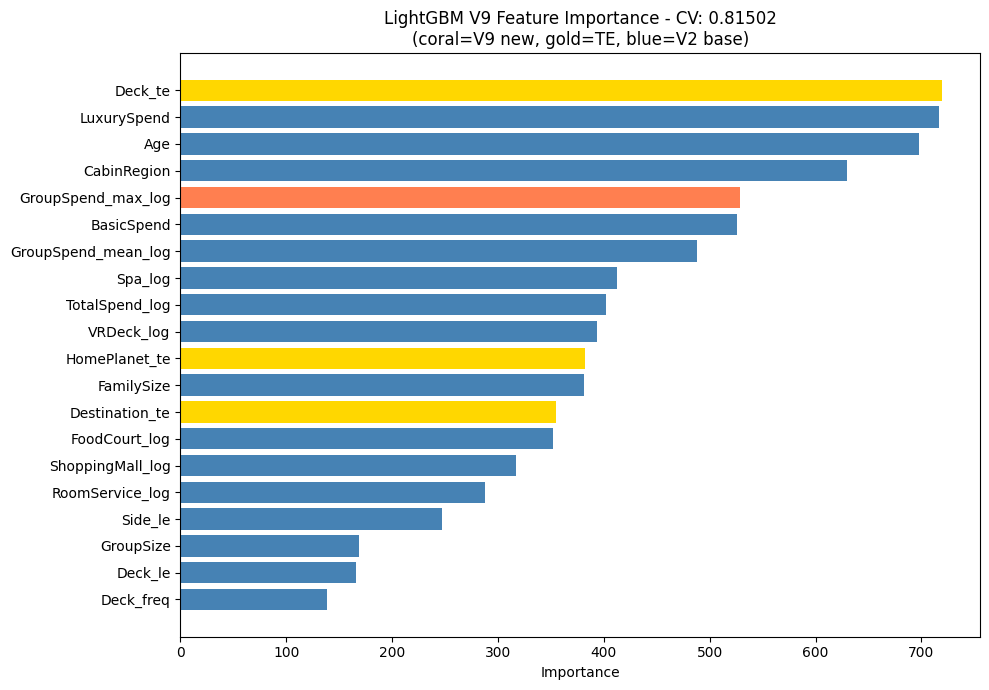

In [15]:
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(20)

plt.figure(figsize=(10, 7))
colors = ['coral' if f == 'GroupSpend_max_log' else ('gold' if f.endswith('_te') else 'steelblue') 
          for f in fi_df['feature']]
plt.barh(fi_df['feature'], fi_df['importance'], color=colors)
plt.title(f'LightGBM V9 Feature Importance - CV: {lgb_acc:.5f}\n(coral=V9 new, gold=TE, blue=V2 base)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Ensemble Analysis & Submissions

In [16]:
print('=== V9 Individual Model Results ===')
print(f'LightGBM:    {lgb_acc:.5f}')
print(f'XGBoost:     {xgb_acc:.5f}')
print(f'CatBoost:    {cb_acc:.5f}')
print(f'ExtraTrees:  {et_acc:.5f}')
print(f'RandomForest:{rf_acc:.5f}')

# OOF correlations
print('\n=== OOF Correlations ===')
oof_all = pd.DataFrame({
    'LGB': oof_lgb, 'XGB': oof_xgb, 'CB': oof_cb, 'ET': oof_et, 'RF': oof_rf
})
print(oof_all.corr().round(4))

=== V9 Individual Model Results ===
LightGBM:    0.81502
XGBoost:     0.81537
CatBoost:    0.81744
ExtraTrees:  0.80709
RandomForest:0.80732

=== OOF Correlations ===
        LGB     XGB      CB      ET      RF
LGB  1.0000  0.9937  0.9894  0.9712  0.9792
XGB  0.9937  1.0000  0.9883  0.9670  0.9746
CB   0.9894  0.9883  1.0000  0.9678  0.9739
ET   0.9712  0.9670  0.9678  1.0000  0.9860
RF   0.9792  0.9746  0.9739  0.9860  1.0000


In [17]:
# === ENSEMBLE STRATEGIES ===

# 1. 3-Model GBDT Average (like V5)
oof_3avg = (oof_lgb + oof_xgb + oof_cb) / 3
acc_3avg = accuracy_score(y, (oof_3avg > 0.5).astype(int))
test_3avg = (test_lgb + test_xgb + test_cb) / 3

# 2. 5-Model Equal Average
oof_5avg = (oof_lgb + oof_xgb + oof_cb + oof_et + oof_rf) / 5
acc_5avg = accuracy_score(y, (oof_5avg > 0.5).astype(int))
test_5avg = (test_lgb + test_xgb + test_cb + test_et + test_rf) / 5

# 3. 5-Model Weighted (GBDT heavier, ET/RF lighter for diversity)
w_lgb, w_xgb, w_cb, w_et, w_rf = 0.25, 0.25, 0.25, 0.125, 0.125
oof_5w = w_lgb*oof_lgb + w_xgb*oof_xgb + w_cb*oof_cb + w_et*oof_et + w_rf*oof_rf
acc_5w = accuracy_score(y, (oof_5w > 0.5).astype(int))
test_5w = w_lgb*test_lgb + w_xgb*test_xgb + w_cb*test_cb + w_et*test_et + w_rf*test_rf

# 4. Majority voting (5 models)
votes = ((oof_lgb > 0.5).astype(int) + (oof_xgb > 0.5).astype(int) + 
         (oof_cb > 0.5).astype(int) + (oof_et > 0.5).astype(int) + 
         (oof_rf > 0.5).astype(int))
acc_vote = accuracy_score(y, (votes >= 3).astype(int))

# 5. Optimized grid search on weights
best_acc = 0
best_weights = None
for w_gbdt in np.arange(0.20, 0.36, 0.01):
    for w_tree in np.arange(0.05, 0.21, 0.01):
        w_rem = 1.0 - 3*w_gbdt - 2*w_tree
        if abs(w_rem) > 0.01:  # must sum to ~1
            continue
        oof_try = w_gbdt*oof_lgb + w_gbdt*oof_xgb + w_gbdt*oof_cb + w_tree*oof_et + w_tree*oof_rf
        acc_try = accuracy_score(y, (oof_try > 0.5).astype(int))
        if acc_try > best_acc:
            best_acc = acc_try
            best_weights = (w_gbdt, w_tree)

if best_weights:
    w_g, w_t = best_weights
    oof_opt = w_g*oof_lgb + w_g*oof_xgb + w_g*oof_cb + w_t*oof_et + w_t*oof_rf
    acc_opt = accuracy_score(y, (oof_opt > 0.5).astype(int))
    test_opt = w_g*test_lgb + w_g*test_xgb + w_g*test_cb + w_t*test_et + w_t*test_rf
else:
    acc_opt = acc_5w
    test_opt = test_5w
    w_g, w_t = 0.25, 0.125

print('=== ENSEMBLE RESULTS ===')
print(f'3-Model GBDT Avg:       {acc_3avg:.5f}')
print(f'5-Model Equal Avg:      {acc_5avg:.5f}')
print(f'5-Model Weighted:       {acc_5w:.5f}  (GBDT 0.25 each, ET/RF 0.125 each)')
print(f'5-Model Majority Vote:  {acc_vote:.5f}')
print(f'5-Model Optimized:      {acc_opt:.5f}  (GBDT {w_g:.2f} each, ET/RF {w_t:.2f} each)')

print(f'\n=== VERSION COMPARISON ===')
print(f'V1: CV 0.82653 | LB 0.80196 | 49 features')
print(f'V2: CV 0.81410 | LB 0.80710 | 29 features')
print(f'V3: CV 0.81836 | LB 0.80406 | 56 features')
print(f'V4: CV 0.81456 | LB 0.80547 | 33 features')
print(f'V5: CV 0.81767 | LB 0.80874 | 32 features (BEST LB)')
print(f'V8: CV 0.82112 | LB TBD     | 39 features')
print(f'V9: CV {acc_opt:.5f} | LB TBD     | {len(features)} features (V5 + 1 feature + 5 models)')

=== ENSEMBLE RESULTS ===
3-Model GBDT Avg:       0.81686
5-Model Equal Avg:      0.81652
5-Model Weighted:       0.81744  (GBDT 0.25 each, ET/RF 0.125 each)
5-Model Majority Vote:  0.81617
5-Model Optimized:      0.81824  (GBDT 0.27 each, ET/RF 0.09 each)

=== VERSION COMPARISON ===
V1: CV 0.82653 | LB 0.80196 | 49 features
V2: CV 0.81410 | LB 0.80710 | 29 features
V3: CV 0.81836 | LB 0.80406 | 56 features
V4: CV 0.81456 | LB 0.80547 | 33 features
V5: CV 0.81767 | LB 0.80874 | 32 features (BEST LB)
V8: CV 0.82112 | LB TBD     | 39 features
V9: CV 0.81824 | LB TBD     | 33 features (V5 + 1 feature + 5 models)


In [18]:
# === SUBMISSIONS ===

# Primary: best ensemble (optimized weights)
final_preds = (test_opt > 0.5)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})
submission['Transported'] = submission['Transported'].astype(bool)
submission.to_csv('../submissions/submission_v9.csv', index=False)

assert submission.shape[0] == sample_sub.shape[0]
assert list(submission.columns) == list(sample_sub.columns)

print(f'V9 Primary (Optimized 5-model): saved to submissions/submission_v9.csv')
print(f'  True: {final_preds.sum()}, False: {(~final_preds).sum()}, Ratio: {final_preds.mean():.4f}')

# Safe fallback: 3-model GBDT average (closest to V5 which had best LB)
final_safe = (test_3avg > 0.5)
submission_safe = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_safe
})
submission_safe['Transported'] = submission_safe['Transported'].astype(bool)
submission_safe.to_csv('../submissions/submission_v9_3model.csv', index=False)

print(f'\nV9 Safe (3-GBDT avg): saved to submissions/submission_v9_3model.csv')
print(f'  True: {final_safe.sum()}, False: {(~final_safe).sum()}, Ratio: {final_safe.mean():.4f}')

# How many predictions differ between the two?
diff = (final_preds != final_safe).sum()
print(f'\nDifferences between 5-model and 3-model: {diff} ({diff/len(final_preds)*100:.1f}%)')

V9 Primary (Optimized 5-model): saved to submissions/submission_v9.csv
  True: 2192, False: 2085, Ratio: 0.5125

V9 Safe (3-GBDT avg): saved to submissions/submission_v9_3model.csv
  True: 2219, False: 2058, Ratio: 0.5188

Differences between 5-model and 3-model: 53 (1.2%)
